In [2]:
! pip install -qU langchain-groq
! pip install ipython
! pip install -qU langchain-cohere

In [3]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

llm=ChatGroq(
    api_key=os.environ['GROQ_API_KEY'],
    model='llama-3.3-70b-versatile',
    temperature=0.7
)



In [10]:
from langchain_openai import AzureChatOpenAI
if not os.getenv("AZURE_OPENAI_API_KEY"):
    os.environ['AZURE_OPENAI_API_KEY']="AIvfkCNPltTC8L7G7NidzdbJvTLhzWOzX2rxn5CMB765Vyb5IzsTJQQJ99BEACfhMk5XJ3w3AAAAACOGxFXc"
llm=AzureChatOpenAI(
    
    azure_endpoint=os.environ["AZURE_ENDPOINT"],
    azure_deployment=os.environ['AZURE_DEPLOYMENT'],
    openai_api_version=os.environ['AZURE_API_VERSION'],
    temperature=0.6
)

messages=[
    (
        "system",
        "you are a helpful assistant that answers any asked human question"
    ),
    (
        "human",
        "which is the largest country in the world"
    )
    
]

llm_res=llm.invoke(messages)
llm_res
# llm_res

APIConnectionError: Connection error.

In [3]:
# add a tool 
from langchain_core.tools import tool
@tool(description="this is a tool that is used to perform multiplication")
def multiply(a:int, b:int) ->int:
    """Multiply a  and b

    Args:
      a:first number
      b:second number 

    """
    return a * b


@tool(description="tool used to perform addition calculations")
def add(a:int, b:int)->int:
    """Adds a  and b

    Args:
      a:first number
      b:second number 

    """
    return a * b



In [47]:
# retriever tool
from pinecone import Pinecone
import cohere
import logging
logging.basicConfig(level=logging.DEBUG)
from langchain_core.messages import SystemMessage,HumanMessage
# from langchain.schema import Document 
def queryvecstore(query):
    pc=Pinecone (api_key=os.environ['PINECONE_API'])
    co=cohere.ClientV2(api_key=os.environ['COHERE_API_KEY'])
   
    embeddings=co.embed(texts=[query],model="embed-english-v3.0",input_type="search_query",embedding_types=['float'])
    queryembeddings=embeddings.embeddings.float
    logging.debug("query embeddings",queryembeddings)
    index=pc.Index('lexifile')
    results=index.query(
        namespace="lexi-78d9c735",
        vector=queryembeddings,
        top_k=4,
        include_metadata=True,  
        include_values=True
    )

    print(results['matches'][0])
    prompt = [
    SystemMessage(content=f"""
You are a helpful assistant that evaluates whether a retrieved document is relevant to a user's question.

Given:
- The user's question
- The retrieved response
- The similarity score

Your task:
1. Check if the response is clearly and directly related to the user's question.
2. If the score is high enough and the response is relevant, refine the response to better align with the user's question.
3. If there is no clear relevance or the score is too low, respond with only: "Not in the document".

User's question:
{query}

Retrieved response:
{results['matches'][0]['metadata']['text']}

Similarity score:
{results['matches'][0].get('score', 0)}
"""),
    HumanMessage(content="Please evaluate and respond.")
]
    res=llm.invoke(prompt)

    return res
query="what are data mining goals"
queryvecstore(query)

{'id': '2',
 'metadata': {'chunk_index': 2.0,
              'text': '10\n'
                      'Chapter 2\n'
                      'Data Mining Goals\n'
                      'As you work with business and data analysts to define a '
                      'technical solution to the business problem,\n'
                      'remember to keep things concrete.\n'
                      'Task List\n'
                      '\x84Describe thetypeof data mining problem, such as '
                      'clustering, prediction, or classification.\n'
                      '\x84Document technical goals using specific units of '
                      'time, such as predictions with a three-month\n'
                      'validity.\n'
                      '\x84If possible, provide actual numbers for desired '
                      'outcomes, such as producing churn scores for\n'
                      '80% of existing customers.\n'
                      'E-Retail Example—Data Mining Goals\n'
     

AIMessage(content='The retrieved response is clearly and directly related to the user\'s question about data mining goals. The similarity score of 0.664763331 is relatively high, indicating a strong connection between the response and the question.\n\nUpon refining the response to better align with the user\'s question, the most relevant information is:\n\nData mining goals involve defining a technical solution to a business problem, keeping things concrete, and describing the type of data mining problem, such as clustering, prediction, or classification. The goals should be specific, measurable, and achievable, with clear benchmarks for evaluating success.\n\nSome examples of data mining goals include:\n\n* Using historical information to generate a model that links "related" items\n* Using Web logs to determine what customers are trying to find and redesigning the site to highlight these items\n* Using Web logs to predict where a person is going next on the site\n\nOverall, the respo

In [50]:
! pip install -qU langchain-cohere

In [22]:
# using langgraph to retrieve the documents
from langchain_pinecone import PineconeVectorStore
from langchain_cohere import CohereEmbeddings
from pinecone import Pinecone
from langchain_core.documents import Document
from typing_extensions import TypedDict,List
from langchain import hub
from langchain_core.prompts import PromptTemplate
from  langgraph.graph import START,StateGraph
pc=Pinecone(api_key=os.environ['PINECONE_API'])
index=pc.Index('lexifile')
# namespace="lexi-78d9c735"
import getpass
import os

if not os.getenv("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass.getpass("Enter  Cohere API key: ")
embeddings=CohereEmbeddings(model="embed-english-v3.0")

def retriever(query,namespace="lexi-78d9c735"):
    vectore_store=PineconeVectorStore(embedding=embeddings,index=index,namespace=namespace)
    # prompt=hub.pull("rlm/rag-prompt")
    template="""
           You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
           If the answer is not explicitly found, but can be inferred, respond intelligently and say it is not directly stated.  
            If you cannot answer or infer from the context, politely reply with: "Not provided in the context."
             Use three sentences maximum and keep the answer concise.
             
            Only if the answer was explicitly found or inferred from the context, politely add a follow-up question or suggestion that is relevant to the user's question and based on the information found in the context. The follow-up should sound natural and helpful, not like a system label.
            Question: {question} 
            Context: {context} 
            Answer:
         """
    
    prompt=PromptTemplate.from_template(template)

    class State(TypedDict):
        question:str
        context:List[Document]
        answer:str

    def retrieve(state:State):
        retrieved_docs=vectore_store.similarity_search(state["question"])
        return {"context":retrieved_docs}
    
    def generate(state:State):
        docs_content="\n\n".join(doc.page_content for doc in state["context"])
        messages=prompt.format(question=state["question"],context=docs_content)
        # messages=prompt.invoke({"question":state["question"], "context":docs_content},"add a follow up related to the users question")
        response=llm.invoke(messages)
        return {"answer":response.content}

    graph_builder=StateGraph(State).add_sequence([retrieve,generate])
    graph_builder.add_edge(START,"retrieve")
    graph=graph_builder.compile()
    response=graph.invoke({"question":query})
    print("response",response)
    return response["answer"]


retriever("what is the document talking about ")








response {'question': 'what is the document talking about ', 'context': [Document(id='3', metadata={'chunk_index': 3.0}, page_content='15\nData Understanding\n\x84\nValue types.Data can take a variety of formats, such asnumeric,categorical(string), or\nBoolean(true/false).Payingattentiontovaluetypecanheadoffproblemsduringlater\nmodeling.\n\x84Coding schemes.Frequently, values in the database are representations of characteristics\nsuch as gender or product type. For example, one data set may useMandFto represent\nmaleandfemale, while another may use the numeric values1and2. Note any conflicting\nschemes in the data report.\nWith this knowledge in hand, you are now ready to write thedata description reportand share\nyourfindings with a larger audience.\nE-Retail Example—Describing Data\nA Web-Mining Scenario Using CRISP-DM\nThere are many records and attributes to process in a W\neb-mining application. Even though the\ne-retailer conducting this data mining project has limited the initi

'The document is talking about the CRISP-DM process, a methodology for data mining projects, and its various phases, including business understanding, data understanding, data preparation, modeling, evaluation, and deployment. It provides guidance on how to conduct data mining projects effectively, including assessing business needs, collecting and preparing data, building models, and evaluating results. Would you like to know more about a specific phase of the CRISP-DM process?'

In [13]:
from langchain_core.tools import StructuredTool
query_tool=StructuredTool.from_function(
    func=retriever,
    name="retriever",
    description="Retrieve relevant information from the document based on the input query",
    return_direct=True
)

In [49]:
from langchain import hub

prompt=hub.pull("rlm/rag-prompt")

print(prompt)

/home/spencer/.local/share/virtualenvs/codes-CswL-_vv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [17]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

checkpointer=InMemorySaver()

agent=create_react_agent(
    llm,
    tools=[multiply,add,query_tool],
    prompt="you are a helpful assistant that leverages the tools provided to give an answer, if there is no tool to use , respond with your own answer intelligently;"
    "always a follow up prompt related to the users question",
    checkpointer=checkpointer
)
message=[HumanMessage(content="what is the summary of the document")]
# # message=[HumanMessage(content="")]
config={"configurable":{"thread_id":"1"}}
response=agent.invoke({"messages":message},config)

# message2=[HumanMessage(content="what about the united states of America ")]
# myresponse=agent.invoke({"messages":[{"role":"user","content":"what about america"}]},config)
# response=agent.invoke({
#     "messages":[{"role":"user","content":"what is 1/3 added to 72"}]
# })

# print(response)



# for res in myresponse:
#     print(res)
# agent.get_graph.draw_mermaid_png()

/home/spencer/.local/share/virtualenvs/codes-CswL-_vv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response {'question': 'summary', 'context': [], 'answer': "There is no context provided to summarize. I don't have any information to work with. I don't know the answer to the question."}


In [27]:
# for res in myresponse['messages'][-1]:
#     print(res)

print(myresponse['messages'][-1].content)

The current President of the United States is Joe Biden. He was inaugurated as the 46th President of the United States on January 20, 2021. Would you like to know more about his administration's policies or recent updates on his presidency?


In [30]:
newmes=[HumanMessage(content="what is the addition of 60 and 73")]
finalres=agent.invoke({"messages":newmes},config)
for res in finalres['messages']:
    print(res)

print(finalres['messages'][-1].content)


content='who is the presidetnt of kenya ' additional_kwargs={} response_metadata={} id='8ce90d9a-fe09-4fcf-8c36-71efeccfd3dc'
content='The current President of Kenya is William Ruto. He was sworn in as the fifth President of Kenya on September 13, 2022, after winning the presidential election held on August 9, 2022. Would you like to know more about his policies or achievements so far?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 337, 'total_tokens': 396, 'completion_time': 0.379519445, 'prompt_time': 0.017287885, 'queue_time': 0.09414413199999999, 'total_time': 0.39680733}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e91e6fbd56', 'finish_reason': 'stop', 'logprobs': None} id='run--91679a73-8634-47c9-a305-0a2b6e116f3e-0' usage_metadata={'input_tokens': 337, 'output_tokens': 59, 'total_tokens': 396}
content='what about america' additional_kwargs={} response_metadata={} id='423fcfd0-c701-47c1-a4fc-38e3c4207be2'


In [23]:
import sys
print(sys.executable)


/home/spencer/.local/share/virtualenvs/codes-CswL-_vv/bin/python


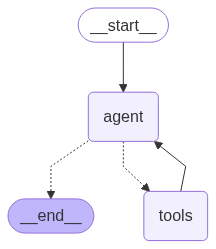

In [24]:
from IPython.display import Image,display
display(Image(agent.get_graph().draw_mermaid_png()))